## Google ColabでscRNA-seq解析

Google ColabはGoogleが提供するクラウドサービスで、対応しているのはPythonのみですが、無料でGPUを使うことができるのが魅力です。お手軽に深層学習を試してみたい場合には重宝します。
実行した設定は保存されないため、毎回ライブラリをインストールする必要がありますが、一般的なデータ解析ライブラリ群（行列演算や機械学習など）は既にインストールされているので、インストールの手間はそれほどないでしょう。

Python，Google Colaboratoryについては様々な参考資料や解説サイトがあります．例えば，以下のような資料も参考にしてください．

* [Python学習サイト集](https://qiita.com/kita33/items/8891c7c04b664e7669bf)
* [ゼロからはじめるPython第26回 (Colaboratorの使い方について）](https://news.mynavi.jp/article/zeropython-26/)
* [Google colaboratory FAQ](https://research.google.com/colaboratory/faq.html)

ここではPythonとGoogle Colabに慣れるため、データ読み込みと正規化、次元削減までを一般的なライブラリのみを用いて実行してみましょう。

**参考: Jupyter と Google Colab との違い**

   HTMLブラウザ上で逐次的にコマンドを実行していくこれらのサービスがJupyter notebook (JupyterLab) です。Jupyter上で行う作業は自分のPC上で行うことになり、解析環境は自分のPCのマシンスペックに依存します。また、Dockerから起動することで、今回のシングルセルツール導入済み環境など、自由な解析環境を作ることができます。

   Google Colab は Google社によって提供されている特殊なJupyter環境であり、Googleのクラウド上にアクセスしている状態になります。そのため解析環境は手元のPCに依存しませんし、GPUを利用することも可能です。一方、Dockerなどを利用することはできず、Googleから提供されている環境のみ利用可能です。そのため環境にインストールされていないライブラリは毎回インストールし直す必要があり、大規模な解析環境構築には不向きです。

### 推奨ブラウザ環境
Google Colaboratory は主要なブラウザはサポートしています．特にChromeとFirefoxでは完全に動作するよう検証されています．

### データ読み込み
[こちらのURL](https://drive.google.com/file/d/1DTbFTjrdRaYeKn0Sg7dMGHDxg3_LMzJ8/view?usp=sharing) からサンプルデータをダウンロードしてください。データサイズは5MBです。 これはPBMCの10種類の細胞を各500細胞ずつ使った5,000細胞のラベルありデータです。コンマで区切られたテキストファイル（csv形式）です。

以降の作業は全てGoogle Colab上で行います。

In [0]:
# ライブラリ読み込み（下記のライブラリは全てGoogle Colabにインストール済です）
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [0]:
# ローカルからファイルのアップロード
from google.colab import files
f=files.upload()

In [0]:
input_data = pd.read_csv("PBMC_10cell_types_total.csv.gz", index_col=0)
input_data.shape

(32738, 5000)

In [0]:
input_data.head()

,CCCATGTGTACGCA-1,AGCGGGCTAGAAGT-1,AGTCTACTTGGGAG-1,TCGGCACTTCTCAT-1,CTCCGAACCTCAAG-1,TAACTAGACGAGTT-1,CGACCGGACAGGAG-1,CCCTACGATCCTAT-1,CCAAGTGAGCGTAT-1,TTGATCTGTTACCT-1,GGGAAGTGTCTCTA-1,ATTAACGACAATCG-1,AAATCAACAGTTCG-1,GGCACGTGGCGTAT-1,GGACGCTGCTCATT-1,ACCGAAACCCTTTA-1,ACGATCGATACGCA-1,ACCTCGTGAAGTAG-1,AGCACTGAACCAGT-1,GCGTATGAGCCTTC-1,TTATCCGACTAGAC-1,TAGAGAGAGGATCT-1,CATCAACTAGTACC-1,AAGATGGATCGCTC-1,ACAAGCACTATCGG-1,TTAGGGTGAGCTAC-1,GATCGTGATGTTTC-1,CCTAGAGATTCCGC-1,GGACCCGAGCATCA-1,CGTTATACACTGGT-1,AGCAAGCTGGACTT-1,AAGAAGACGGGAGT-1,CAACGTGATCCTGC-1,TTAGGTCTTTGAGC-1,GAGCGCACCTACTT-1,CATGGCCTACTACG-1,AATCGGTGCAATCG-1,ACGGGAGAGGTATC-1,ACGGATTGCCCTCA-1,CTATCAACTGGAAA-1,...,AAGAATCTGTCACA-1,TTGGAGACGGCATT-1,AAGCGTACCCGCTT-1,GGAATCTGTATCTC-1,ACAATTGAGGCATT-1,CCCTCAGATGCAAC-1,ATCGAGTGGCCATA-1,CCTGAGCTCGTAAC-1,TAGCGATGAAGGGC-1,AGTTTAGATGTGCA-1,TATGCGGACTATTC-1,TGCTGAGATACGAC-1,GTGTAGTGAACAGA-1,ATGGGTACAGCGGA-1,GGCACTCTAACGGG-1,CCCTAGTGTAGACC-1,CTAGATCTGTAAAG-1,GAAGATGACTAGTG-1,CAACAGACATCAGC-1,TCGAGAACGTCGAT-1,GTGTCAGACTTGCC-1,CGCATAGATGGAGG-1,CCCTTACTGCATCA-1,TTCCCACTATACCG-1,AGTACTCTGGGATG-1,AATCCTTGTTCTAC-1,ATTAGATGTCAGGT-1,ACCTGAGAGAATGA-1,TAATCCACGATAAG-1,GCTAGAACAACAGA-1,TCGCACTGAGGTTC-1,CAAGCTGAGAATAG-1,AGACTCGACCGAAT-1,TGACGATGCGCATA-1,AGCACAACTTTGTC-1,CAAACTCTGCTTCC-1,GCGAAGGATCACCC-1,GAGCGGCTTCTTAC-1,GAATGGCTGGTAGG-1,CGTAACGAGTTTGG-1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 細胞のアノテーション
細胞はバーコードで表されています。これを細胞名に変更します。（これは細胞名が既知である場合のみ可能です）

In [0]:
ncells = 500
cellname = ["regulatory_t", "cd56_nk", "naive_cytotoxic", "cytotoxic_t", "b_cell", 
            "memory_t", "naive_t", "cd4_helper_t", "cd14_monocytes", "cd34"]
labels= []
for cell in cellname:
    labels += [cell] * ncells

In [0]:
input_data.columns = labels
input_data.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### フィルタリング・正規化

In [0]:
## 全細胞で発現量0の遺伝子を除外
df = input_data
print("number of all genes: ", df.shape[0])

zero = np.all(df == 0, axis=1)
nonzero = np.logical_not(zero)
df = df[nonzero]
print("number of nonzero genes: ", df.shape[0])

number of all genes:  32738
number of nonzero genes:  16936


In [0]:
df.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
colsum = df.sum()
df = df / colsum * 10000
df = np.log1p(df)
df.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 次元削減
%%time はセルの実行時間を計測するためのマジックコマンドです。

In [0]:
%%time
A = input_data.T
pca = PCA()
pca.fit(A)
PC = pca.transform(A)

In [0]:
df = pd.DataFrame({ 'PC1' : PC[:,0], 'PC2' : PC[:,1], 'cell' : labels})
df.head()

,PC1,PC2,cell
0,-55.430436,-15.587875,regulatory_t
1,-36.970853,-15.305738,regulatory_t
2,-4.585877,-27.489627,regulatory_t
3,-27.250011,7.034446,regulatory_t
4,-53.932927,-6.328488,regulatory_t


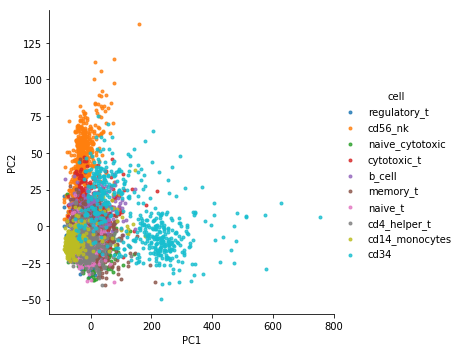

In [0]:
sns.lmplot(x="PC1", y="PC2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

In [0]:
%%time
model = TSNE(n_components=2, perplexity=20, n_iter=5000, verbose=1, random_state=0)
tsne = model.fit_transform(PC[:,0:9])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 5.517987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.392365
[t-SNE] KL divergence after 5000 iterations: 1.176739
CPU times: user 2min 21s, sys: 493 ms, total: 2min 21s
Wall time: 2min 22s


In [0]:
df = pd.DataFrame({ 'tSNE_1' : tsne[:,0], 'tSNE_2' : tsne[:,1], 'cell' : labels})
df.head()

,tSNE_1,tSNE_2,cell
0,45.105087,-73.942757,regulatory_t
1,10.286850,-98.783768,regulatory_t
2,-55.505276,-48.110096,regulatory_t
3,-11.595157,-69.937439,regulatory_t
4,36.551498,-67.068512,regulatory_t


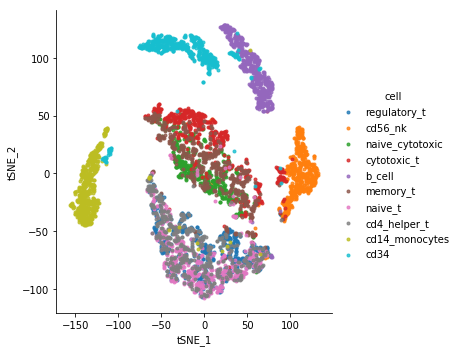

In [0]:
sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

In [0]:
import umap
um = umap.UMAP().fit_transform(PC[:,0:9])

In [0]:
df = pd.DataFrame({ 'UMAP_1' : um[:,0], 'UMAP_2' : um[:,1], 'cell' : labels})
df.head()

,UMAP_1,UMAP_2,cell
0,-2.087032,6.527436,regulatory_t
1,-3.898192,5.645320,regulatory_t
2,-4.200012,1.749664,regulatory_t
3,-4.024286,3.966290,regulatory_t
4,-2.136032,5.425051,regulatory_t


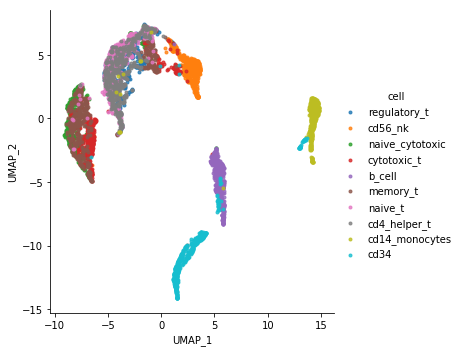

In [0]:
sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()